# 아이리스 데이터 분석 - 로지스틱 회귀분석

아이리스 데이터셋을 사용하여 **로지스틱 회귀(Logistic Regression)** 알고리즘으로 품종을 분류하는 지도 학습 예제입니다.

## 1. 필요한 라이브러리 임포트

In [1]:
# 데이터 처리
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'AppleGothic' if plt.rcParams['font.family'][0] == 'DejaVu Sans' else plt.rcParams['font.family']
plt.rcParams['axes.unicode_minus'] = False

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 임포트 완료!")

라이브러리 임포트 완료!


## 2. 데이터 로드 및 탐색

In [2]:
# 아이리스 데이터셋 로드
iris = load_iris()

# DataFrame으로 변환
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target
df['species_name'] = df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

print("데이터셋 정보:")
print(f"데이터 크기: {df.shape}")
print(f"\n특성(Features): {iris.feature_names}")
print(f"\n품종(Target): {iris.target_names}")
print("\n데이터 미리보기:")
df.head(10)

데이터셋 정보:
데이터 크기: (150, 6)

특성(Features): ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

품종(Target): ['setosa' 'versicolor' 'virginica']

데이터 미리보기:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
5,5.4,3.9,1.7,0.4,0,setosa
6,4.6,3.4,1.4,0.3,0,setosa
7,5.0,3.4,1.5,0.2,0,setosa
8,4.4,2.9,1.4,0.2,0,setosa
9,4.9,3.1,1.5,0.1,0,setosa


In [3]:
# 기본 통계 정보
print("기술 통계:")
df.describe()

기술 통계:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [4]:
# 결측치 확인
print("결측치 확인:")
print(df.isnull().sum())

# 품종별 데이터 개수
print("\n품종별 데이터 개수:")
print(df['species_name'].value_counts())

결측치 확인:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
species_name         0
dtype: int64

품종별 데이터 개수:
species_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


## 3. 데이터 시각화

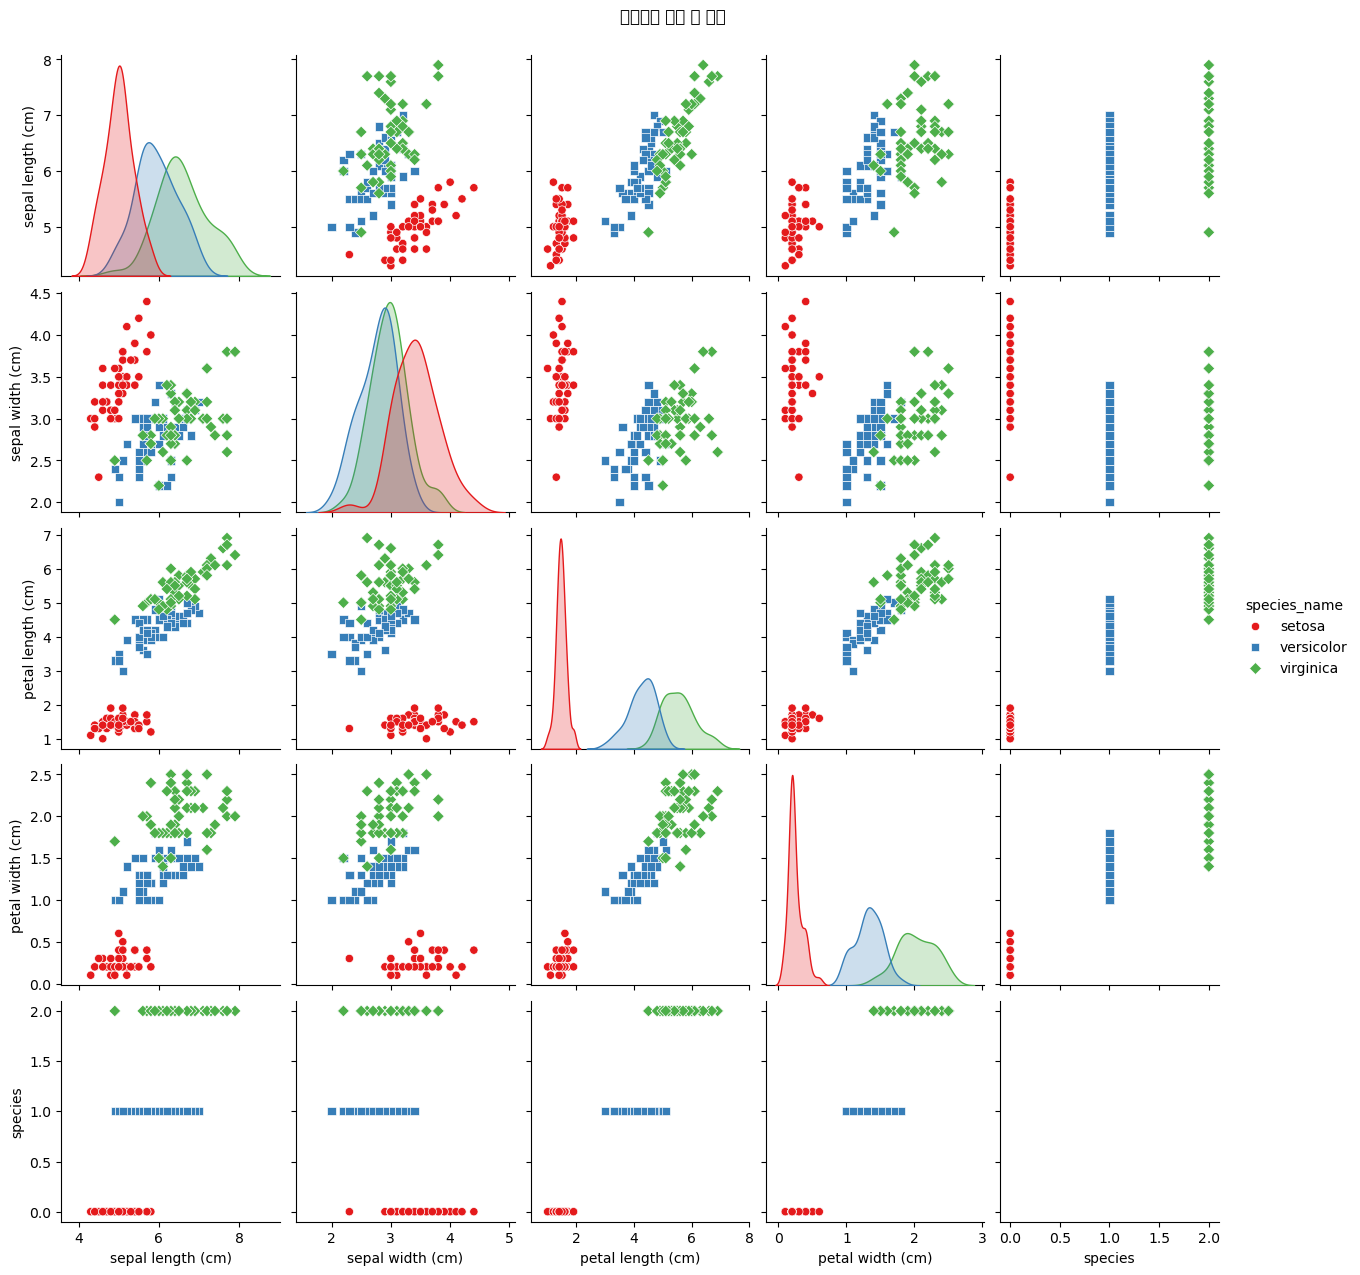

In [5]:
# 특성 간 관계 시각화 (Pairplot)
sns.pairplot(df, hue='species_name', markers=['o', 's', 'D'], palette='Set1')
plt.suptitle('아이리스 특성 간 관계', y=1.02)
plt.show()

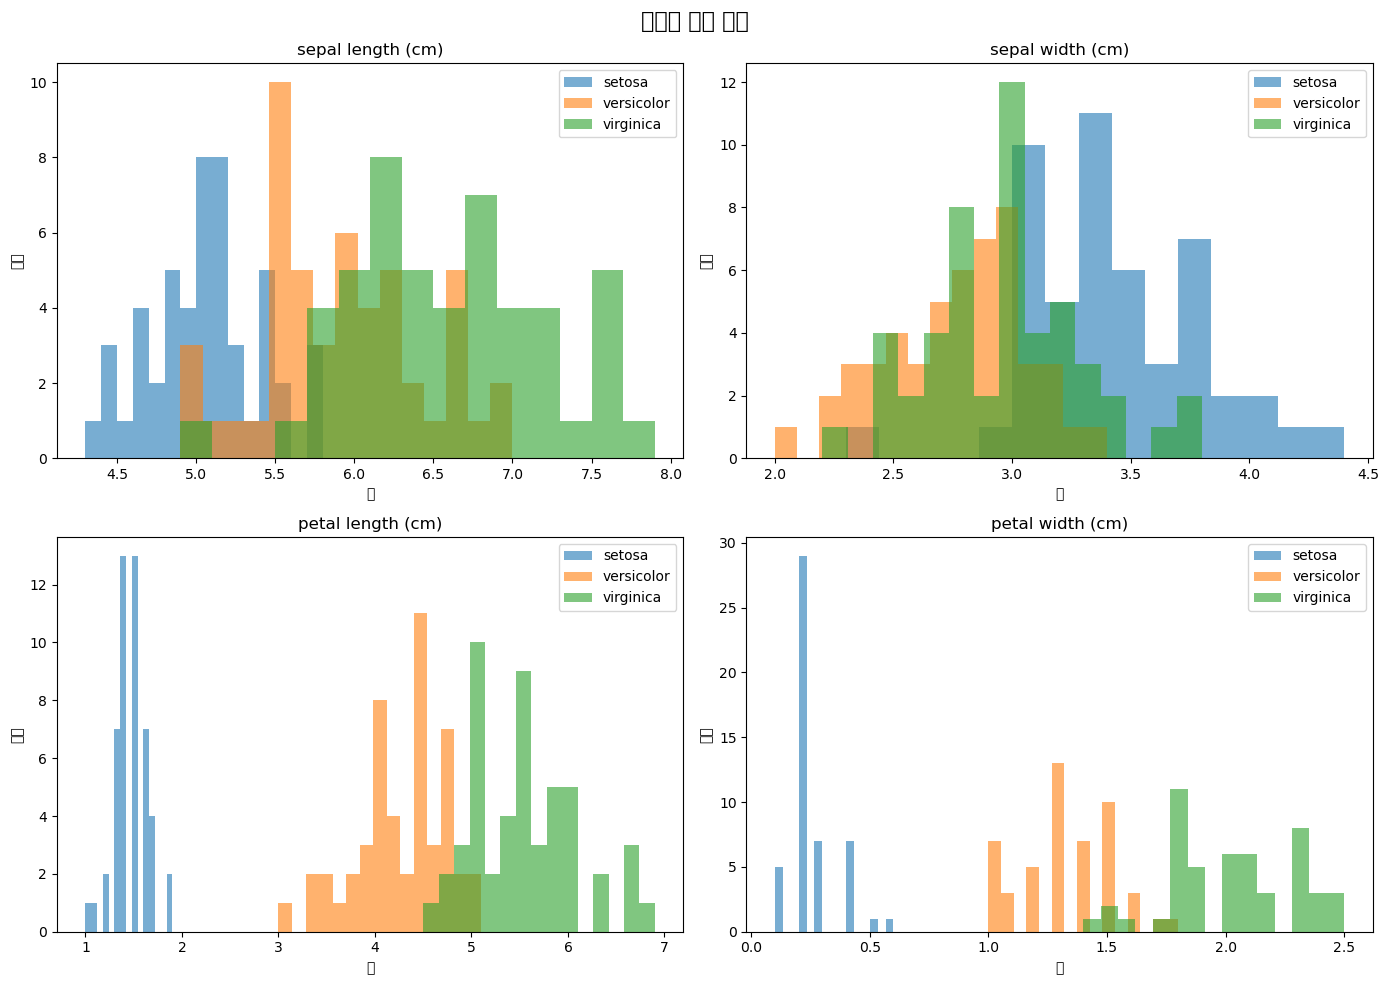

In [6]:
# 특성별 분포 (히스토그램)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('품종별 특성 분포', fontsize=16)

for idx, col in enumerate(iris.feature_names):
    ax = axes[idx // 2, idx % 2]
    for species in df['species_name'].unique():
        subset = df[df['species_name'] == species]
        ax.hist(subset[col], alpha=0.6, label=species, bins=15)
    ax.set_title(col)
    ax.set_xlabel('값')
    ax.set_ylabel('빈도')
    ax.legend()

plt.tight_layout()
plt.show()

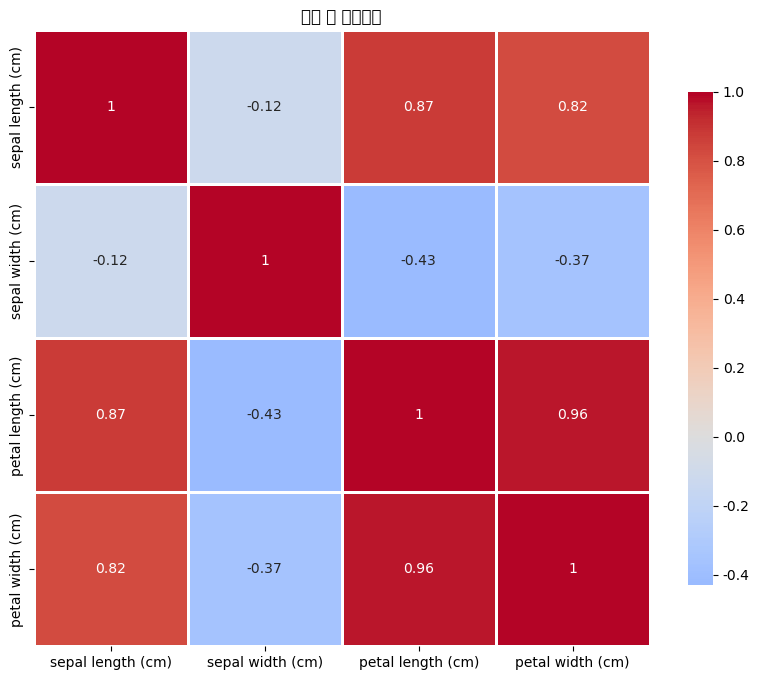


상관관계 행렬:
                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000  


In [7]:
# 상관관계 히트맵
plt.figure(figsize=(10, 8))
correlation = df[iris.feature_names].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('특성 간 상관관계')
plt.show()

print("\n상관관계 행렬:")
print(correlation)

## 4. 데이터 전처리

In [8]:
# 특성(X)과 타겟(y) 분리
X = iris.data
y = iris.target

print(f"특성 데이터 크기: {X.shape}")
print(f"타겟 데이터 크기: {y.shape}")

특성 데이터 크기: (150, 4)
타겟 데이터 크기: (150,)


In [9]:
# 훈련 데이터와 테스트 데이터 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"훈련 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")
print(f"\n훈련 데이터 품종 분포:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"\n테스트 데이터 품종 분포:\n{pd.Series(y_test).value_counts().sort_index()}")

훈련 데이터 크기: (120, 4)
테스트 데이터 크기: (30, 4)

훈련 데이터 품종 분포:
0    40
1    40
2    40
Name: count, dtype: int64

테스트 데이터 품종 분포:
0    10
1    10
2    10
Name: count, dtype: int64


In [10]:
# 특성 스케일링 (표준화)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("스케일링 전 훈련 데이터 통계:")
print(f"평균: {X_train.mean(axis=0)}")
print(f"표준편차: {X_train.std(axis=0)}")

print("\n스케일링 후 훈련 데이터 통계:")
print(f"평균: {X_train_scaled.mean(axis=0)}")
print(f"표준편차: {X_train_scaled.std(axis=0)}")

스케일링 전 훈련 데이터 통계:
평균: [5.84166667 3.04833333 3.77       1.205     ]
표준편차: [0.837415   0.44665112 1.761136   0.75947899]

스케일링 후 훈련 데이터 통계:
평균: [-1.20829273e-15 -2.03679666e-15  4.99600361e-16  1.67458640e-15]
표준편차: [1. 1. 1. 1.]


## 5. 로지스틱 회귀 모델 학습

In [11]:
# 로지스틱 회귀 모델 생성
# multi_class='multinomial': 다중 클래스 분류를 위한 소프트맥스 회귀
# solver='lbfgs': 최적화 알고리즘
# max_iter=200: 최대 반복 횟수
logistic_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=200,
    random_state=42
)

# 모델 학습
logistic_model.fit(X_train_scaled, y_train)

print("로지스틱 회귀 모델 학습 완료!")
print(f"\n클래스: {logistic_model.classes_}")
print(f"반복 횟수: {logistic_model.n_iter_}")

로지스틱 회귀 모델 학습 완료!

클래스: [0 1 2]
반복 횟수: [16]


## 6. 모델 계수 분석

In [12]:
# 모델 계수 (가중치) 확인
coefficients = pd.DataFrame(
    logistic_model.coef_,
    columns=iris.feature_names,
    index=iris.target_names
)

print("로지스틱 회귀 계수 (가중치):")
print(coefficients)

# 절편 (bias)
print("\n절편 (Intercept):")
intercepts = pd.Series(logistic_model.intercept_, index=iris.target_names)
print(intercepts)

로지스틱 회귀 계수 (가중치):
            sepal length (cm)  sepal width (cm)  petal length (cm)  \
setosa              -1.088945          1.024208          -1.799056   
versicolor           0.536337         -0.360487          -0.204074   
virginica            0.552608         -0.663721           2.003130   

            petal width (cm)  
setosa             -1.686228  
versicolor         -0.807957  
virginica           2.494185  

절편 (Intercept):
setosa       -0.305587
versicolor    1.908556
virginica    -1.602969
dtype: float64


<Figure size 1200x600 with 0 Axes>

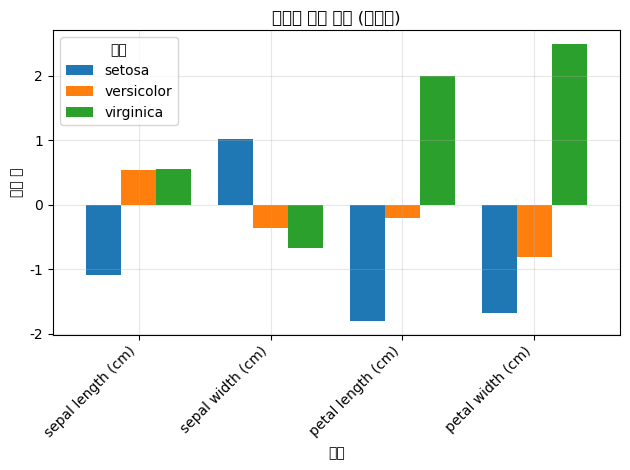

In [13]:
# 계수 시각화
plt.figure(figsize=(12, 6))
coefficients.T.plot(kind='bar', width=0.8)
plt.title('품종별 특성 계수 (가중치)')
plt.xlabel('특성')
plt.ylabel('계수 값')
plt.xticks(rotation=45, ha='right')
plt.legend(title='품종')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. 모델 예측 및 평가

In [14]:
# 예측
y_pred = logistic_model.predict(X_test_scaled)

# 정확도 계산
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = logistic_model.score(X_train_scaled, y_train)

print(f"테스트 데이터 정확도: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"훈련 데이터 정확도: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

테스트 데이터 정확도: 0.9333 (93.33%)
훈련 데이터 정확도: 0.9583 (95.83%)


In [15]:
# 분류 리포트
print("분류 리포트:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

분류 리포트:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



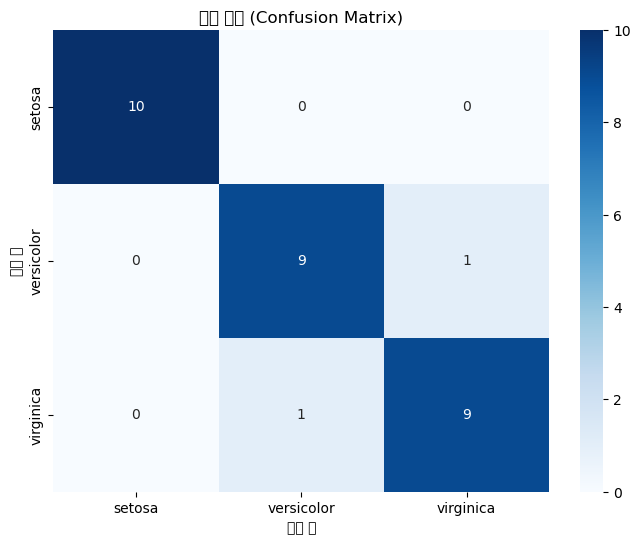


혼동 행렬:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


In [16]:
# 혼동 행렬 (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=iris.target_names, 
            yticklabels=iris.target_names)
plt.title('혼동 행렬 (Confusion Matrix)')
plt.ylabel('실제 값')
plt.xlabel('예측 값')
plt.show()

print("\n혼동 행렬:")
print(cm)

## 8. 교차 검증 (Cross-Validation)

교차 검증 결과 (5-Fold):
각 Fold 정확도: [0.91666667 0.95833333 0.95833333 0.95833333 1.        ]
평균 정확도: 0.9583 (±0.0264)


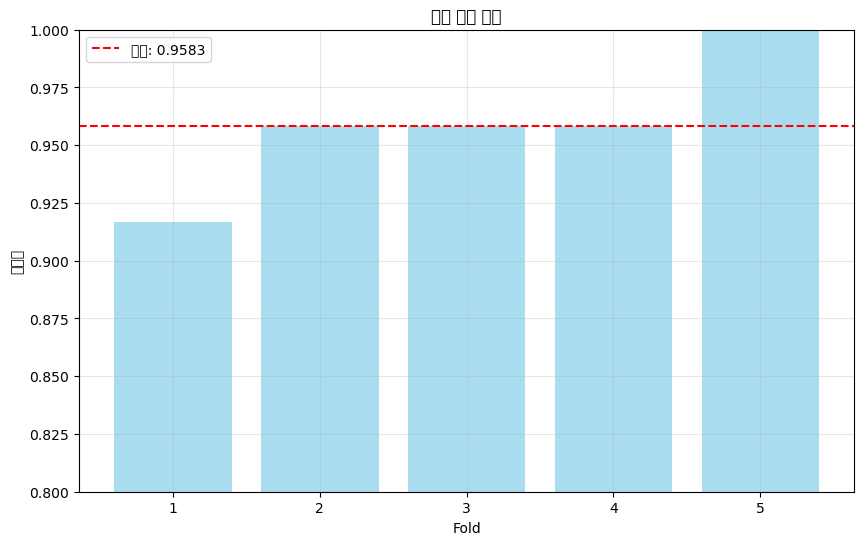

In [17]:
# 5-Fold 교차 검증
cv_scores = cross_val_score(
    logistic_model, X_train_scaled, y_train, cv=5, scoring='accuracy'
)

print("교차 검증 결과 (5-Fold):")
print(f"각 Fold 정확도: {cv_scores}")
print(f"평균 정확도: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, alpha=0.7, color='skyblue')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', 
            label=f'평균: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('정확도')
plt.title('교차 검증 결과')
plt.ylim([0.8, 1.0])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. 예측 확률 분석

테스트 데이터 예측 확률 (처음 10개):
   setosa 확률  versicolor 확률  virginica 확률         실제값         예측값
0   0.978818       0.021182  3.638218e-07      setosa      setosa
1   0.003798       0.369220  6.269815e-01   virginica   virginica
2   0.148799       0.842475  8.726064e-03  versicolor  versicolor
3   0.095445       0.894619  9.936370e-03  versicolor  versicolor
4   0.988493       0.011507  1.725496e-07      setosa      setosa
5   0.018047       0.675523  3.064298e-01  versicolor  versicolor
6   0.996230       0.003770  2.970222e-08      setosa      setosa
7   0.941042       0.058957  1.299214e-06      setosa      setosa
8   0.000412       0.143891  8.556974e-01   virginica   virginica
9   0.059959       0.737093  2.029482e-01  versicolor  versicolor


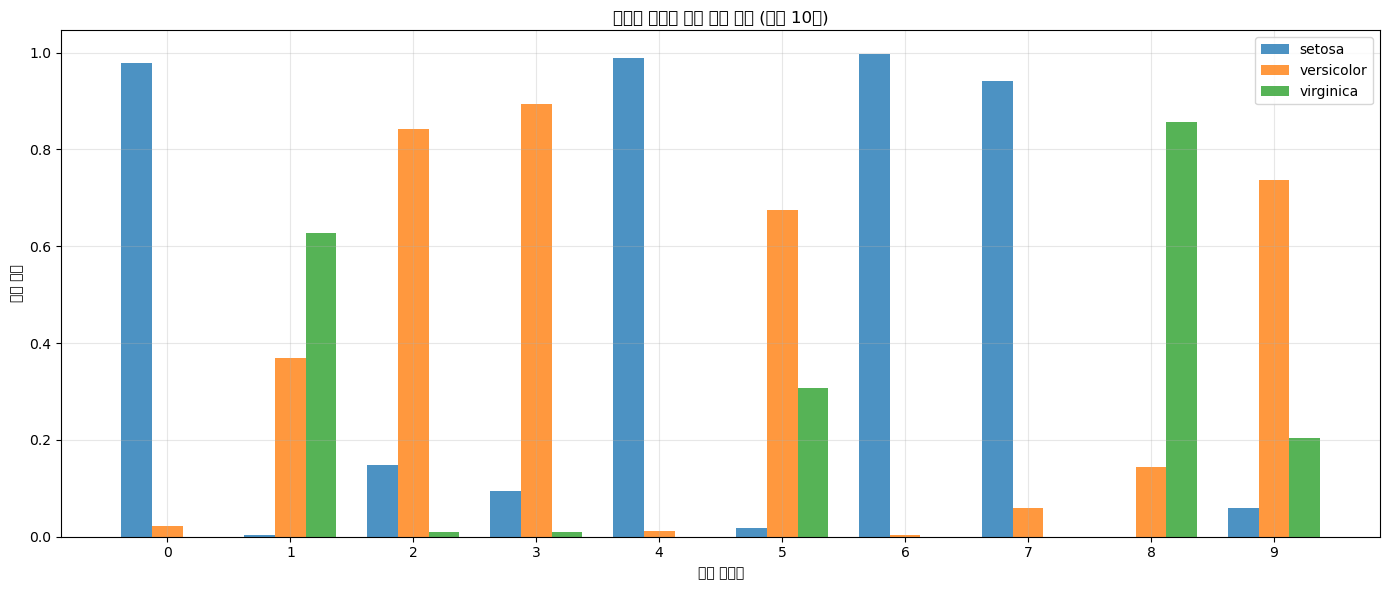

In [18]:
# 예측 확률
y_pred_proba = logistic_model.predict_proba(X_test_scaled)

# 테스트 데이터의 처음 10개에 대한 예측 확률
proba_df = pd.DataFrame(
    y_pred_proba[:10],
    columns=[f'{name} 확률' for name in iris.target_names]
)
proba_df['실제값'] = [iris.target_names[i] for i in y_test[:10]]
proba_df['예측값'] = [iris.target_names[i] for i in y_pred[:10]]

print("테스트 데이터 예측 확률 (처음 10개):")
print(proba_df)

# 확률 분포 시각화
plt.figure(figsize=(14, 6))
x = np.arange(10)
width = 0.25

for i, species in enumerate(iris.target_names):
    plt.bar(x + i*width, y_pred_proba[:10, i], width, 
            label=species, alpha=0.8)

plt.xlabel('샘플 인덱스')
plt.ylabel('예측 확률')
plt.title('테스트 데이터 예측 확률 분포 (처음 10개)')
plt.xticks(x + width, range(10))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. ROC Curve 및 AUC

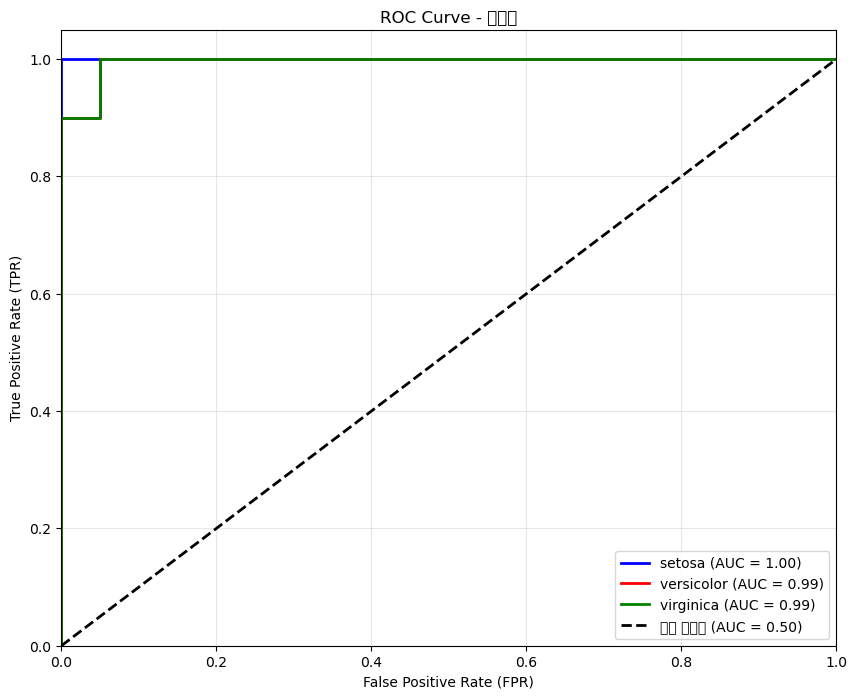


품종별 AUC:
setosa: 1.0000
versicolor: 0.9950
virginica: 0.9950


In [19]:
# 다중 클래스 ROC Curve를 위한 레이블 이진화
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# 각 클래스별 ROC curve와 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Curve 시각화
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{iris.target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='랜덤 분류기 (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - 품종별')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print("\n품종별 AUC:")
for i in range(n_classes):
    print(f"{iris.target_names[i]}: {roc_auc[i]:.4f}")

## 11. 다양한 정규화 파라미터(C) 비교

In [20]:
# 다양한 C 값에 대해 모델 학습 및 평가
# C는 정규화 강도의 역수 (C가 작을수록 정규화가 강함)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
train_scores = []
test_scores = []

for C in C_values:
    model = LogisticRegression(
        C=C,
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=200,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    
    train_scores.append(model.score(X_train_scaled, y_train))
    test_scores.append(model.score(X_test_scaled, y_test))

# 최적의 C 값
best_C = C_values[np.argmax(test_scores)]
best_accuracy = max(test_scores)

print(f"최적의 C 값: {best_C}")
print(f"최고 테스트 정확도: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

최적의 C 값: 10
최고 테스트 정확도: 1.0000 (100.00%)


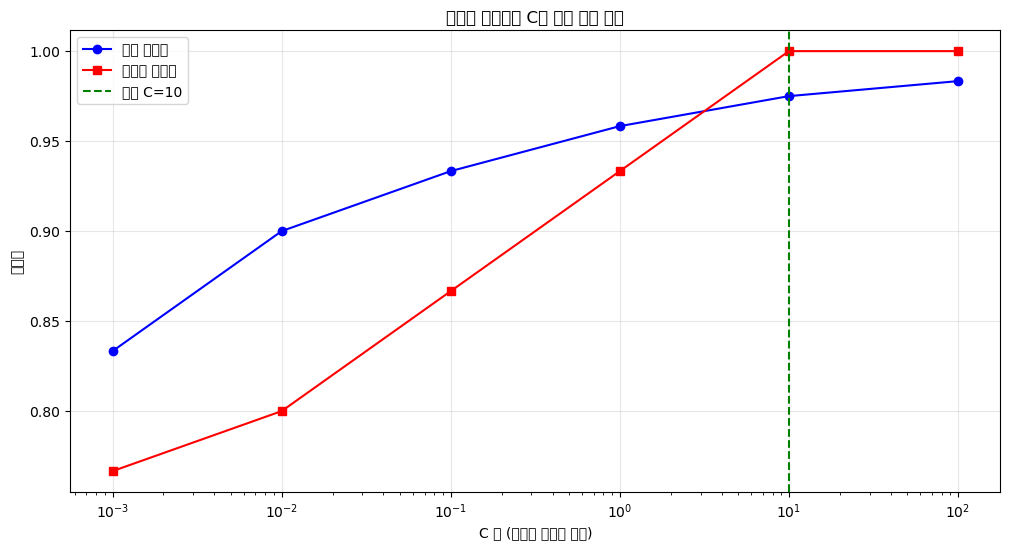

In [21]:
# C 값에 따른 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(C_values, train_scores, label='훈련 정확도', marker='o', color='blue')
plt.plot(C_values, test_scores, label='테스트 정확도', marker='s', color='red')
plt.axvline(x=best_C, color='green', linestyle='--', label=f'최적 C={best_C}')
plt.xscale('log')
plt.xlabel('C 값 (정규화 강도의 역수)')
plt.ylabel('정확도')
plt.title('정규화 파라미터 C에 따른 모델 성능')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 12. 새로운 데이터 예측 예제

In [22]:
# 새로운 샘플 데이터 (sepal length, sepal width, petal length, petal width)
new_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],  # setosa 같은 특성
    [6.5, 3.0, 5.2, 2.0],  # virginica 같은 특성
    [5.9, 3.0, 4.2, 1.5]   # versicolor 같은 특성
])

# 스케일링
new_samples_scaled = scaler.transform(new_samples)

# 예측
predictions = logistic_model.predict(new_samples_scaled)
probabilities = logistic_model.predict_proba(new_samples_scaled)

print("새로운 데이터 예측 결과:\n")
for i, sample in enumerate(new_samples):
    pred_name = iris.target_names[predictions[i]]
    print(f"샘플 {i+1}: {sample}")
    print(f"  → 예측 품종: {pred_name}")
    print(f"  → 확률: setosa={probabilities[i][0]:.3f}, versicolor={probabilities[i][1]:.3f}, virginica={probabilities[i][2]:.3f}")
    print()

새로운 데이터 예측 결과:

샘플 1: [5.1 3.5 1.4 0.2]
  → 예측 품종: setosa
  → 확률: setosa=0.981, versicolor=0.019, virginica=0.000

샘플 2: [6.5 3.  5.2 2. ]
  → 예측 품종: virginica
  → 확률: setosa=0.000, versicolor=0.144, virginica=0.856

샘플 3: [5.9 3.  4.2 1.5]
  → 예측 품종: versicolor
  → 확률: setosa=0.033, versicolor=0.812, virginica=0.155



## 13. 결과 요약 및 비교

In [23]:
print("=" * 60)
print("로지스틱 회귀 모델 학습 결과 요약")
print("=" * 60)
print(f"데이터셋 크기: {len(iris.data)}개")
print(f"특성(Features) 개수: {len(iris.feature_names)}개")
print(f"품종(Classes) 개수: {len(iris.target_names)}개")
print(f"\n훈련/테스트 분할: {len(X_train)}/{len(X_test)}")
print(f"\n테스트 정확도: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"훈련 정확도: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"교차 검증 평균 정확도: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"\n최적 정규화 파라미터 C: {best_C}")
print("=" * 60)

# 테스트 데이터 예측 결과 DataFrame
results_df = pd.DataFrame({
    '실제값': [iris.target_names[i] for i in y_test],
    '예측값': [iris.target_names[i] for i in y_pred],
    '정답여부': ['O' if y_test[i] == y_pred[i] else 'X' for i in range(len(y_test))]
})

print("\n테스트 데이터 예측 결과 샘플 (처음 10개):")
print(results_df.head(10))

print(f"\n총 {len(y_test)}개 중 {sum(y_test == y_pred)}개 정답")

로지스틱 회귀 모델 학습 결과 요약
데이터셋 크기: 150개
특성(Features) 개수: 4개
품종(Classes) 개수: 3개

훈련/테스트 분할: 120/30

테스트 정확도: 0.9333 (93.33%)
훈련 정확도: 0.9583 (95.83%)
교차 검증 평균 정확도: 0.9583 (±0.0264)

최적 정규화 파라미터 C: 10

테스트 데이터 예측 결과 샘플 (처음 10개):
          실제값         예측값 정답여부
0      setosa      setosa    O
1   virginica   virginica    O
2  versicolor  versicolor    O
3  versicolor  versicolor    O
4      setosa      setosa    O
5  versicolor  versicolor    O
6      setosa      setosa    O
7      setosa      setosa    O
8   virginica   virginica    O
9  versicolor  versicolor    O

총 30개 중 28개 정답


## 📚 학습 포인트

### 로지스틱 회귀의 특징

1. **작동 원리**: 
   - 선형 결합 후 시그모이드/소프트맥스 함수를 통해 확률로 변환
   - 다중 클래스의 경우 One-vs-Rest 또는 Multinomial 방식 사용
   
2. **확률적 해석**: 
   - 각 클래스에 속할 확률을 직접 제공
   - 불확실성 정량화 가능
   
3. **해석 가능성**: 
   - 계수(가중치)를 통해 각 특성의 영향력 파악 가능
   - 모델의 의사결정 과정 이해 용이

### 주요 하이퍼파라미터

- **C (정규화 강도의 역수)**: 
  - C가 작으면: 강한 정규화, 과적합 방지
  - C가 크면: 약한 정규화, 복잡한 모델
  
- **multi_class**: 
  - 'ovr': One-vs-Rest (이진 분류를 여러 번)
  - 'multinomial': Multinomial (소프트맥스 회귀)
  
- **solver**: 
  - 'lbfgs': 작은 데이터셋에 적합
  - 'sag', 'saga': 큰 데이터셋에 적합

### 장단점

**장점**:
- 확률 출력으로 불확실성 측정 가능
- 계수 해석이 용이
- 학습 속도가 빠름
- 작은 데이터셋에서도 잘 작동
- 과적합 방지를 위한 정규화 내장

**단점**:
- 선형 결정 경계만 학습 가능
- 비선형 패턴에는 특성 공학 필요
- 특성 간 상관관계에 민감할 수 있음

### KNN과 비교

| 특성 | 로지스틱 회귀 | KNN |
|------|--------------|-----|
| 학습 속도 | 빠름 | 매우 빠름 (lazy learning) |
| 예측 속도 | 빠름 | 느림 (모든 데이터와 거리 계산) |
| 해석 가능성 | 높음 (계수 확인) | 낮음 |
| 확률 출력 | 자연스러움 | 가능하지만 단순함 |
| 메모리 사용 | 적음 | 많음 (모든 데이터 저장) |
| 결정 경계 | 선형 | 비선형 |

### 다음 단계

- 다른 분류 알고리즘 시도 (SVM, Decision Tree, Random Forest, Neural Network)
- GridSearchCV로 하이퍼파라미터 자동 최적화
- 특성 선택 및 특성 공학
- 앙상블 기법 적용
- 실제 데이터에 적용